In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
df = pd.read_csv('vehicles_prep.csv')
df.head()


,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,33590,2014.0,gmc,good,8 cylinders,gas,57923,clean,other,4wd,pickup,white,al
1,22590,2010.0,chevrolet,good,8 cylinders,gas,71229,clean,other,4wd,pickup,blue,al
2,39590,2020.0,chevrolet,good,8 cylinders,gas,19160,clean,other,4wd,pickup,red,al
3,30990,2017.0,toyota,good,8 cylinders,gas,41124,clean,other,fwd,pickup,red,al
4,15000,2013.0,ford,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al


In [ ]:
# 1) Agrupar categorías raras: top 10 + "Other"
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    top10 = df[col].value_counts().nlargest(10).index
    df[col] = df[col].where(df[col].isin(top10), other='Other')

# 2) Prepara X/y y split
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) ColumnTransformer con sparse encoding
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
preprocessor = ColumnTransformer([
    ('num', Pipeline([
         ('imputer', SimpleImputer(strategy='mean')),
         ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
         ('imputer', SimpleImputer(strategy='most_frequent')),
         ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
    ]), cat_cols)
], sparse_threshold=0.1)

# 4) Muestra para buscar α
X_sub, _, y_sub, _ = train_test_split(
    X_train, y_train, train_size=50000, random_state=42
)
X_sub_trans = preprocessor.fit_transform(X_sub)

alphas = np.logspace(0, 3, 10)
best_alpha, best_mse = None, np.inf
for a in alphas:
    m = Ridge(alpha=a).fit(X_sub_trans, y_sub)
    mse = mean_squared_error(y_sub, m.predict(X_sub_trans))
    if mse < best_mse:
        best_mse, best_alpha = mse, a

print("α candidato:", best_alpha)

# 5) Entrena Ridge final con ese α
model = Pipeline([
    ('preproc', preprocessor),
    ('ridge', Ridge(alpha=best_alpha*2))   # puedes ajustar factor para asegurar fuerte regularización
])
model.fit(X_train, y_train)

y_tr = model.predict(X_train)
y_te = model.predict(X_test)
r2_tr = r2_score(y_train, y_tr)
r2_te = r2_score(y_test, y_te)
overf = (r2_tr - r2_te)/abs(r2_tr)*100

print(f"R² Train: {r2_tr:.4f}")
print(f"R² Test:  {r2_te:.4f}")
print(f"Overfitting: {overf:.2f}%")

α candidato: 1.0
R² Train: 0.4460
R² Test:  0.4477
Overfitting: -0.37%


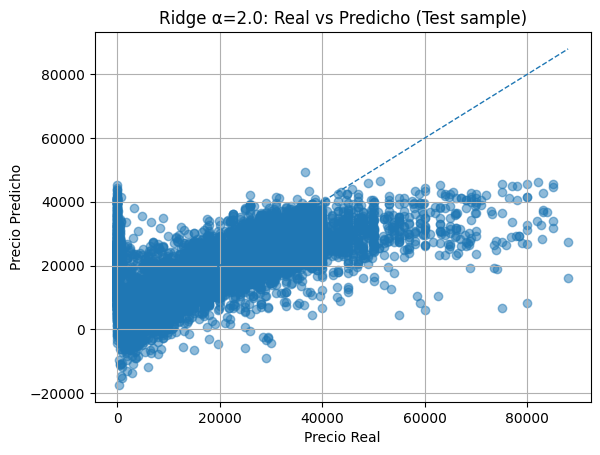

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Carga y agrupa categorías raras
df = pd.read_csv('vehicles_prep.csv')
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    top10 = df[col].value_counts().nlargest(10).index
    df[col] = df[col].where(df[col].isin(top10), other='Other')

# Split inicial
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Muestras para entrenamiento & test (para gráfico)
X_train_s = X_train.sample(50000, random_state=42)
y_train_s = y_train.loc[X_train_s.index]
X_test_s  = X_test.sample(10000, random_state=42)
y_test_s  = y_test.loc[X_test_s.index]

# Preprocesamiento
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
preprocessor = ColumnTransformer([
    ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')),
                      ('scaler', StandardScaler())]), num_cols),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                      ('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
], sparse_threshold=0)

# Modelo Ridge con α=2.0
model = Pipeline([
    ('preproc', preprocessor),
    ('ridge', Ridge(alpha=2.0))
])
model.fit(X_train_s, y_train_s)

# Predicciones y R² sobre la muestra
y_tr_s = model.predict(X_train_s)
y_te_s = model.predict(X_test_s)
r2_tr_s = r2_score(y_train_s, y_tr_s)
r2_te_s = r2_score(y_test_s, y_te_s)

# Gráfica 1: Real vs Predicho (Test sample)
plt.figure()
plt.scatter(y_test_s, y_te_s, alpha=0.5)
plt.plot([y_test_s.min(), y_test_s.max()],
         [y_test_s.min(), y_test_s.max()],
         '--', linewidth=1)
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Ridge α=2.0: Real vs Predicho (Test sample)")
plt.grid(True)
plt.show()

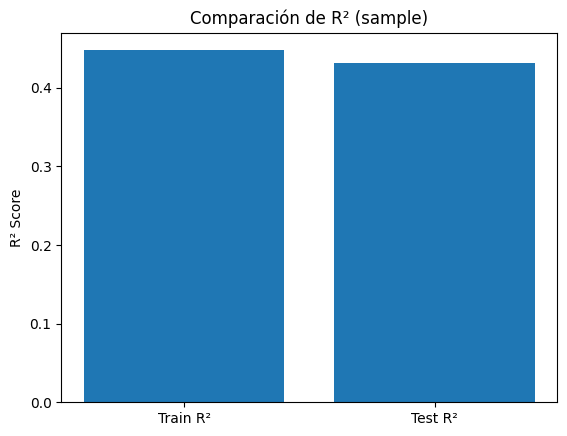

In [ ]:
# Gráfica 2: Comparación de R² (sample)
plt.figure()
plt.bar(["Train R²", "Test R²"], [r2_tr_s, r2_te_s])
plt.ylabel("R² Score")
plt.title("Comparación de R² (sample)")
plt.show()